In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from PIL import Image

from splat.gaussians import Gaussians

from splat.custom_pytorch_implementation.create_image_auto import (
    Camera,
    Gaussian,
    create_image_covariance_test_auto,
    create_image_full_auto,
    create_image_full_auto_multiple_gaussians,
    create_image_full_auto_multiple_gaussians_with_splat_gaussians,
)

from splat.custom_pytorch_implementation.create_image_custom import (
    create_image_full_custom_multiple_gaussians_with_splat_gaussians,
)





def return_gaussians() -> Gaussians:
    point_3d1 = torch.tensor([[0.101, 0.1001, -4]], dtype=torch.float).requires_grad_(True)
    r1 = torch.tensor([[0.5, 0.02, 0.03, 0.001]], dtype=torch.float).requires_grad_(True)
    s1 = torch.tensor([[.1, .15, .2]], dtype=torch.float).requires_grad_(True)
    color1 = torch.tensor([0.4, 0.6, 0.8], dtype=torch.float).requires_grad_(True)
    opacity1 = torch.tensor([0.5], dtype=torch.float).requires_grad_(True)


    point_3d2 = torch.tensor([[0.0999, 0.0999, -4.1]], dtype=torch.float).requires_grad_(True)
    r2 = torch.tensor([[0.2, 0.04, 0.03, 0.001]], dtype=torch.float).requires_grad_(True)
    s2 = torch.tensor([[.2, .16, .1]], dtype=torch.float).requires_grad_(True)
    color2 = torch.tensor([0.1, 0.15, 0.2], dtype=torch.float).requires_grad_(True)
    opacity2 = torch.tensor([0.9], dtype=torch.float).requires_grad_(True)

    return Gaussians(
        points=torch.stack([point_3d1, point_3d2]).squeeze(1),
        colors=torch.stack([color1, color2]).squeeze(1),
        scales=torch.stack([s1, s2]).squeeze(1),
        quaternions=torch.stack([r1, r2]).squeeze(1),
        opacity=torch.stack([opacity1, opacity2]).squeeze(1),
        requires_grad=True
    )

def return_camera() -> Camera:
    focal_x = torch.tensor([100.0])
    focal_y = torch.tensor([100.0])
    width = 32
    height = 32
    camera_rotation = torch.tensor([1, 0, 0, 0]).unsqueeze(0)
    camera_translation = torch.tensor([[-0.1, -0.1, 0.0]])

    return Camera(
        focal_x=focal_x,
        focal_y=focal_y,
        c_x=0.0,
        c_y=0.0,
        width=width,
        height=height,
        camera_rotation=camera_rotation,
        camera_translation=camera_translation,
    )

def return_gt_image() -> torch.Tensor:
    gt_image = Image.open("/Users/derek/Desktop/intro_to_gaussian_splatting/splat/custom_pytorch_implementation/gt.png")
    gt_image = np.array(gt_image) / 255.0
    return torch.tensor(gt_image)

/Users/derek/Desktop/intro_to_gaussian_splatting/splat/custom_pytorch_implementation/auto_functions.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return final_color, torch.tensor(current_T)


mean_3d torch.Size([1, 4])
extrinsic_matrix torch.Size([4, 4])
mean_3d torch.Size([1, 4])
extrinsic_matrix torch.Size([4, 4])


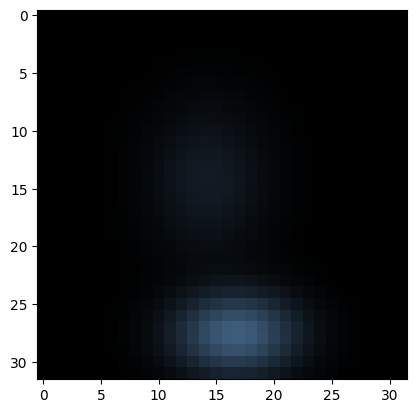

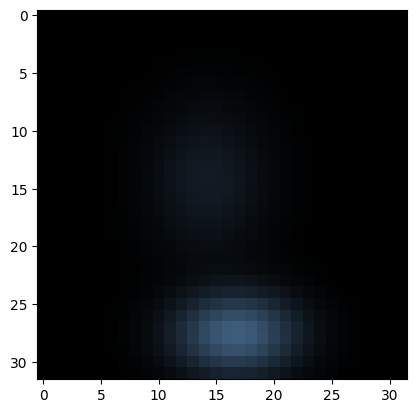

True


In [3]:
camera = return_camera()
gaussians = return_gaussians()
gt_image = return_gt_image()

output_auto1 = create_image_full_auto_multiple_gaussians_with_splat_gaussians(camera, gaussians, camera.height, camera.width)
output_auto2 = create_image_full_custom_multiple_gaussians_with_splat_gaussians(camera, gaussians, camera.height, camera.width)
plt.imshow(output_auto1.detach().numpy())
plt.show()
plt.imshow(output_auto2.detach().numpy())
plt.show()

print(torch.allclose(output_auto1, output_auto2))

# optimizer = torch.optim.Adam([r1, s1, point_3d1, color1, opacity1, r2, s2, point_3d2, color2, opacity2], lr=0.00005)





# gaussians = Gaussians(
#     points=torch.stack([point_3d1, point_3d2]),
#     colors=torch.stack([color1, color2]),
#     scales=torch.stack([s1, s2]),
#     quaternions=torch.stack([r1, r2]),
#     opacity=torch.stack([opacity1, opacity2]),
# )

# pbar = tqdm.tqdm(range(3))
# for i in pbar:
#     optimizer.zero_grad()

#     output_auto = create_image_full_auto_multiple_gaussians(camera, [gaussian1, gaussian2], camera.height, camera.width)

#     loss = (output_auto - gt_image).pow(2).mean()
#     loss.backward(retain_graph=True)
#     optimizer.step()
#     pbar.set_postfix(loss=loss.item())
#     print("loss", loss)
#     print("point_3d grad1", point_3d1.grad)
#     print("R grad1", r1.grad)
#     print("S grad1", s1.grad)
#     print("Color grad1", color1.grad)
#     print("Opacity grad1", opacity1.grad)
#     print("point_3d grad2", point_3d2.grad)
#     print("R grad2", r2.grad)
#     print("S grad2", s2.grad)
#     print("Color grad2", color2.grad)
#     print("Opacity grad2", opacity2.grad)
#     print("\n\n")

    
# print("GT image")
# print("GT image")
# plt.imshow(gt_image)
# plt.show()
# print("Final image")
# plt.imshow(output_auto.detach().numpy())
# plt.show()